In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'colab'

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalizationV2, TimeDistributed, RepeatVector
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

from tensorflow.random import set_seed
set_seed(455)
np.random.seed(455)

In [323]:
data = pd.read_csv('weatherHistory.csv').drop(['Summary', 'Precip Type', 'Apparent Temperature (C)', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover', 'Pressure (millibars)', 'Daily Summary'], axis=1)
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'].str[:-10])
data = data.sort_values(by='Formatted Date', ascending=True)
data.set_index('Formatted Date', inplace=True)
data.head()

,Temperature (C),Humidity
Formatted Date,,
2006-01-01 00:00:00,0.577778,0.89
2006-01-01 01:00:00,1.161111,0.85
2006-01-01 02:00:00,1.666667,0.82
2006-01-01 03:00:00,1.711111,0.82
2006-01-01 04:00:00,1.183333,0.86


In [324]:
# Train Test Split
tstart = pd.to_datetime("2013-01-01", format="%Y-%m-%d")
tend = pd.to_datetime("2015-12-01 00:00", format="%Y-%m-%d %H:%M")
tend_end = pd.to_datetime("2015-12-31 23:00", format="%Y-%m-%d %H:%M")
def train_test_split(data, tstart, tend):
    train = data.loc[f'{tstart}':f'{tend-pd.Timedelta(minutes=1)}', :].values
    test = data.loc[f'{tend}':f'{tend_end}', :].values
    return train, test
train, test = train_test_split(data, tstart, tend)

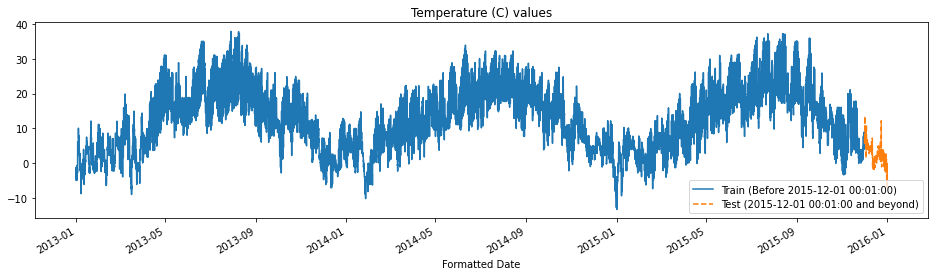

In [325]:
# Plot of the train test split
def train_test_plot(data, tstart, tend, feature):
    data.loc[f"{tstart}":f"{tend}", f"{feature}"].plot(figsize=(16, 4), legend=True)
    data.loc[f"{tend+pd.Timedelta(minutes=1)}":f'{tend_end}', f"{feature}"].plot(figsize=(16, 4), legend=True, linestyle='dashed')
    plt.legend([f"Train (Before {tend+pd.Timedelta(minutes=1)})", f"Test ({tend+pd.Timedelta(minutes=1)} and beyond)"])
    plt.title(f"{feature} values")
    plt.show()

train_test_plot(data,tstart,tend, 'Temperature (C)')

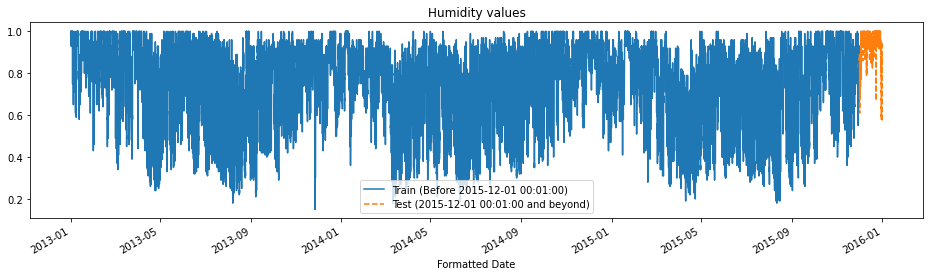

In [326]:
train_test_plot(data,tstart,tend, 'Humidity')

In [327]:
# Train and Test Data Norm
sc = MinMaxScaler(feature_range=(0,1))
train_norm = sc.fit_transform(train)
test_norm = sc.fit_transform(test)

In [328]:
# X,y Split
def split_sequence(input_sequence_length, output_sequence_length, data):
    X, y = [], []
    data_len = data.shape[0]
    for i in range(input_sequence_length, data_len - output_sequence_length):
        X.append(data[i-input_sequence_length:i])
        y.append(data[i:i+output_sequence_length])
    return np.array(X), np.array(y)

input_sequence_length = 200
output_sequence_length = 24
features = 2
X_train, y_train = split_sequence(input_sequence_length, output_sequence_length, train_norm)
y_train = y_train.reshape(-1, output_sequence_length, features)
X_test, y_test = split_sequence(input_sequence_length, output_sequence_length, test_norm)
y_test = y_test.reshape(-1, output_sequence_length, features)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(25309, 200, 2) (25309, 24, 2)
(520, 200, 2) (520, 24, 2)


In [329]:
# Model Building
model = Sequential()
# model.add(LSTM(100, activation='relu', return_sequences=False, input_shape=(input_sequence_length, features)))
model.add(CuDNNLSTM(200, return_sequences=False, input_shape=(input_sequence_length, features)))
model.add(Dropout(0.2))
model.add(BatchNormalizationV2())
model.add(RepeatVector(output_sequence_length))
# model.add(LSTM(130, activation='relu', return_sequences=True))
model.add(CuDNNLSTM(200, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalizationV2())
model.add(TimeDistributed(Dense(features)))

In [330]:
# Model Compilation
model.compile(loss='mse', optimizer='rmsprop')

In [331]:
# Model Callbacks
es = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1, restore_best_weights = True)
mc = ModelCheckpoint('model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

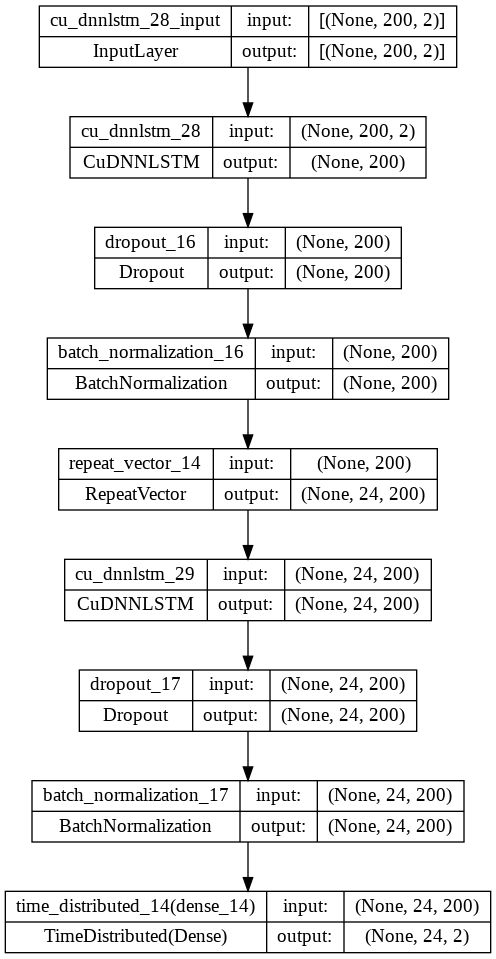

In [332]:
plot_model(model, show_shapes=True)

In [333]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_28 (CuDNNLSTM)   (None, 200)               163200    
                                                                 
 dropout_16 (Dropout)        (None, 200)               0         
                                                                 
 batch_normalization_16 (Bat  (None, 200)              800       
 chNormalization)                                                
                                                                 
 repeat_vector_14 (RepeatVec  (None, 24, 200)          0         
 tor)                                                            
                                                                 
 cu_dnnlstm_29 (CuDNNLSTM)   (None, 24, 200)           321600    
                                                                 
 dropout_17 (Dropout)        (None, 24, 200)         

In [334]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=32, callbacks=[es, mc], verbose=1)

Epoch 1/30
632/633 [============================>.] - ETA: 0s - loss: 0.1776
Epoch 1: val_loss improved from inf to 0.01901, saving model to model.h5
633/633 [==============================] - 14s 19ms/step - loss: 0.1774 - val_loss: 0.0190
Epoch 2/30
631/633 [============================>.] - ETA: 0s - loss: 0.0155
Epoch 2: val_loss improved from 0.01901 to 0.01609, saving model to model.h5
633/633 [==============================] - 11s 17ms/step - loss: 0.0155 - val_loss: 0.0161
Epoch 3/30
632/633 [============================>.] - ETA: 0s - loss: 0.0131
Epoch 3: val_loss improved from 0.01609 to 0.01125, saving model to model.h5
633/633 [==============================] - 11s 18ms/step - loss: 0.0131 - val_loss: 0.0112
Epoch 4/30
632/633 [============================>.] - ETA: 0s - loss: 0.0121
Epoch 4: val_loss did not improve from 0.01125
633/633 [==============================] - 11s 17ms/step - loss: 0.0121 - val_loss: 0.0162
Epoch 5/30
632/633 [============================>.] - 

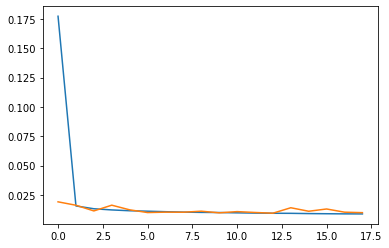

In [335]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [336]:
y_pred = model.predict(X_test)

17/17 [==============================] - 0s 6ms/step


In [337]:
def inverse_transform(y_test, y_pred):
  y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
  y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[-1])
  y_test_inverse = sc.inverse_transform(y_test_reshaped)
  y_pred_inverse = sc.inverse_transform(y_pred_reshaped)
  return y_test_inverse, y_pred_inverse

In [338]:
y_test_inverse, y_pred_inverse = inverse_transform(y_test, y_pred)

In [339]:
# Mean Squared Error (MSE)
MSE = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f'Mean Squared Error (MSE): {MSE:.2f}')

# Mean Absolute Error (MSE)
MAE = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f'Mean Absolute Error (MAE): {MAE:.2f}')

Mean Squared Error (MSE): 1.67
Mean Absolute Error (MAE): 0.69


In [340]:
y_test_inverse_time = y_test_inverse.reshape(int(y_test_inverse.shape[0]/output_sequence_length), output_sequence_length, y_test_inverse.shape[-1])
y_pred_inverse_time = y_pred_inverse.reshape(int(y_pred_inverse.shape[0]/output_sequence_length), output_sequence_length, y_pred_inverse.shape[-1])

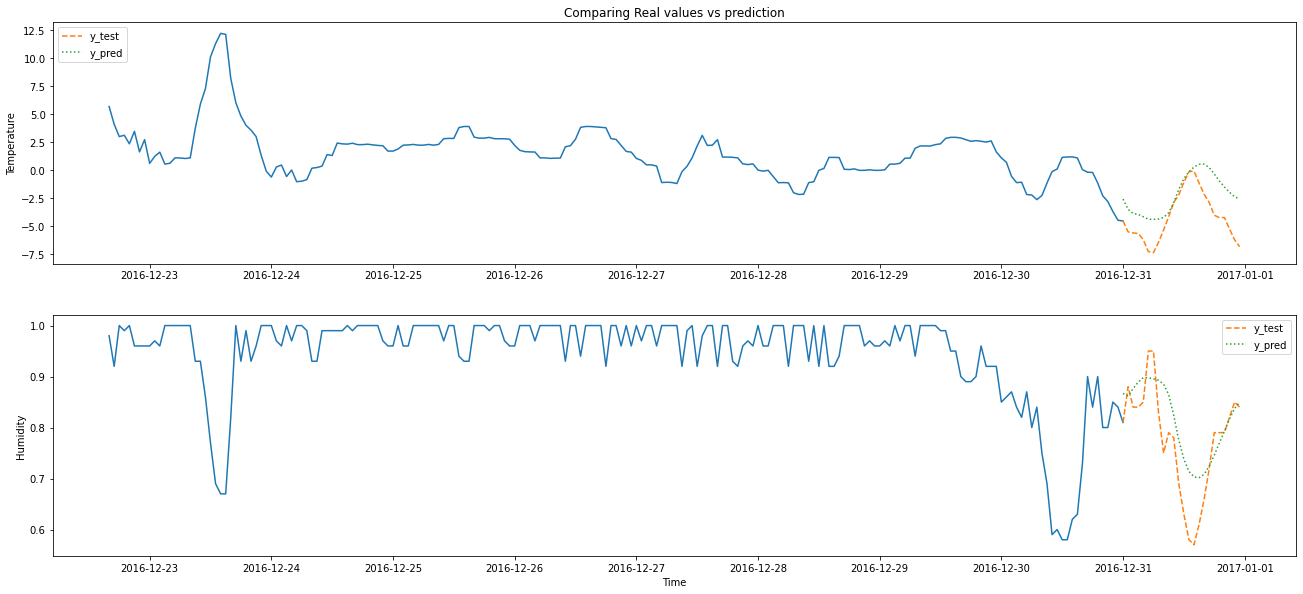

In [341]:
# New Test of plotting
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,8))
f.tight_layout(h_pad=3)
train_values = input_sequence_length + output_sequence_length

ax1.plot(data.index[-train_values:-output_sequence_length+1], test[-train_values:-output_sequence_length+1, 0])
ax1.plot(data.index[-output_sequence_length:], test[-output_sequence_length:, 0], linestyle='dashed', label='y_test')
ax1.plot(data.index[-output_sequence_length:], y_pred_inverse_time[-1, :,0], linestyle='dotted', label='y_pred')
ax1.set_ylabel('Temperature')
ax1.set_title('Comparing Real values vs prediction')
ax1.legend(loc='upper left')

ax2.plot(data.index[-train_values:-output_sequence_length+1], test[-train_values:-output_sequence_length+1, 1])
ax2.plot(data.index[-output_sequence_length:], test[-output_sequence_length:, 1], linestyle='dashed', label='y_test')
ax2.plot(data.index[-output_sequence_length:], y_pred_inverse_time[-1, :,1], linestyle='dotted', label='y_pred')
ax2.set_xlabel('Time')
ax2.set_ylabel('Humidity')
ax2.legend()

plt.show()

In [342]:
# # new data processing to match model pref for prediction
# sc_test.inverse_transform(model.predict(sc_train.fit_transform(np.array(data['MV1'])[-70:].reshape(-1, 1)).reshape(1, -1, 1)))